# Perkenalan

# Import Library

In [1]:
import os
import cv2
import matplotlib.pyplot as plt

# Data Loading

In [5]:
images_dir = 'Dataset/train/images'
labels_dir = 'Dataset/train/labels'

In [7]:
classes_path = 'Dataset/classes.txt'

with open(classes_path, 'r') as f:
    classes = [line.strip() for line in f.readlines()]

print("Class Names:")
for idx, class_name in enumerate(classes):
    print(f"{idx}: {class_name}")


Class Names:
0: Bus
1: Car
2: LicensePlate
3: Motorcycle
4: Truck


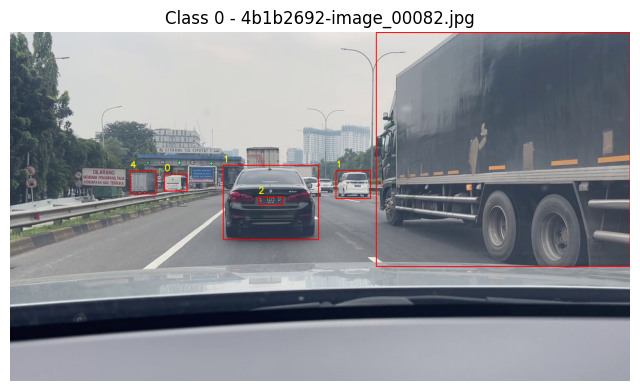

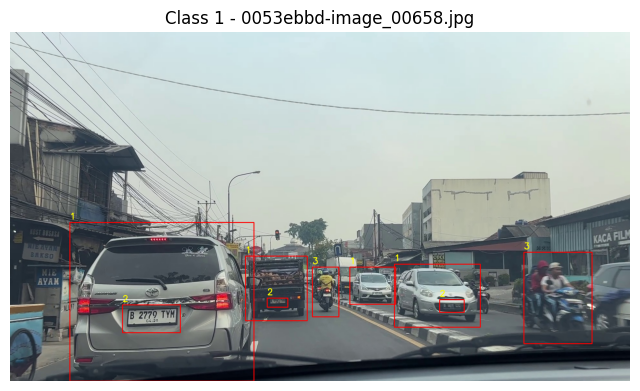

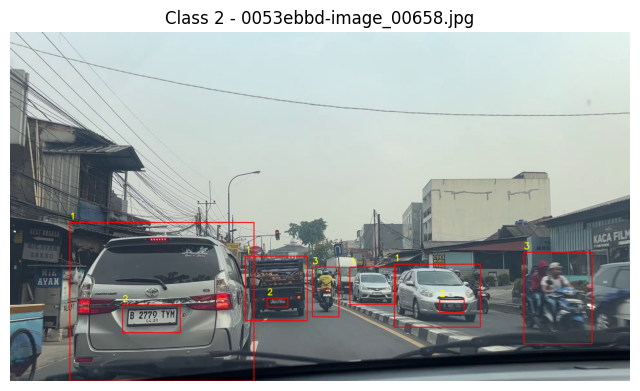

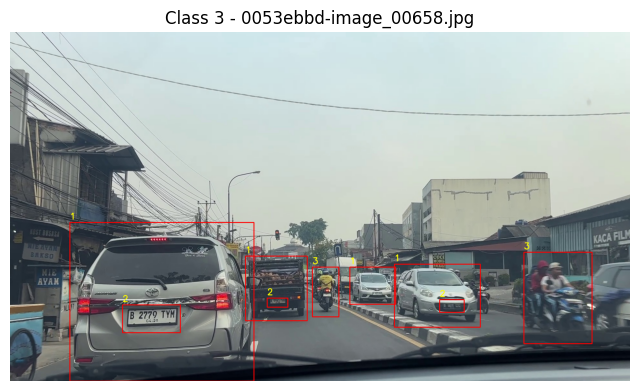

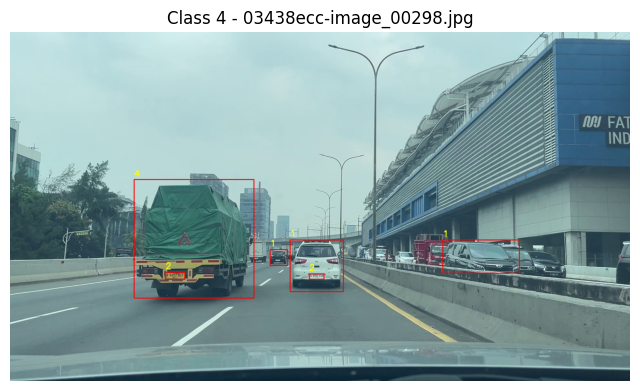

In [ ]:
num_classes = 5
class_examples = dict()  # Simpan image_file per class

image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]

for image_file in image_files:
    label_file = image_file.replace('.jpg', '.txt')
    label_path = os.path.join(labels_dir, label_file)

    if not os.path.exists(label_path):
        continue

    with open(label_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            class_id = int(parts[0])

            if class_id not in class_examples and class_id < num_classes:
                class_examples[class_id] = image_file

    if len(class_examples) == num_classes:
        break

for class_id in sorted(class_examples.keys()):
    image_file = class_examples[class_id]
    image_path = os.path.join(images_dir, image_file)
    label_file = image_file.replace('.jpg', '.txt')
    label_path = os.path.join(labels_dir, label_file)

    image = cv2.imread(image_path)
    if image is None:
        continue
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape

    boxes = []
    with open(label_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            cid = int(parts[0])
            x_center = float(parts[1]) * w
            y_center = float(parts[2]) * h
            width = float(parts[3]) * w
            height = float(parts[4]) * h

            xmin = int(x_center - width / 2)
            ymin = int(y_center - height / 2)
            xmax = int(x_center + width / 2)
            ymax = int(y_center + height / 2)

            boxes.append((cid, xmin, ymin, xmax, ymax))

    for box in boxes:
        cid, xmin, ymin, xmax, ymax = box
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)

        label_text = str(cid)
        cv2.putText(image, label_text, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX,
                    0.9, (255, 255, 0), 2)

    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.title(f"Class {class_id} - {image_file}")
    plt.axis('off')
    plt.show()

# Exploratory Data Analysis

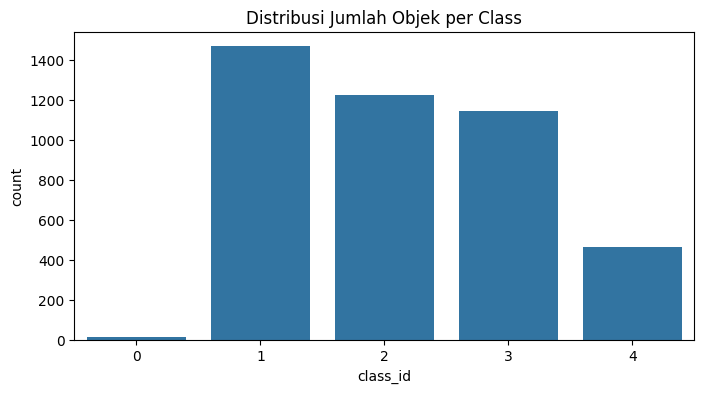

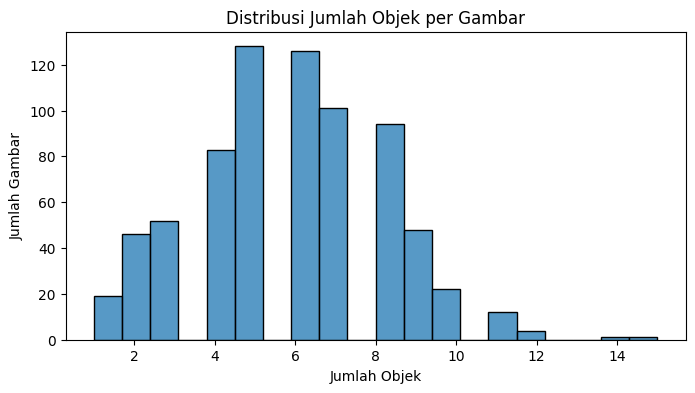

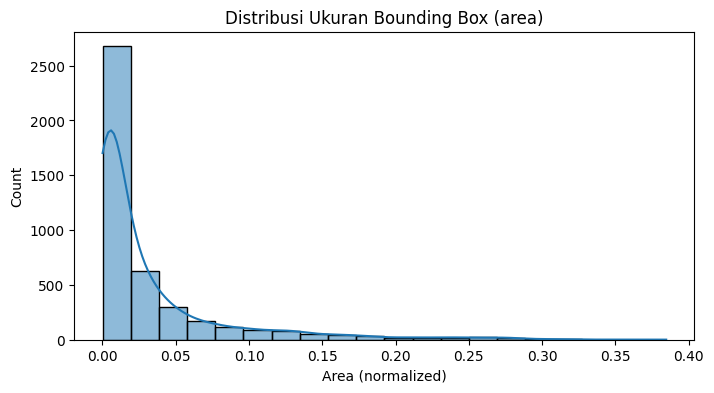

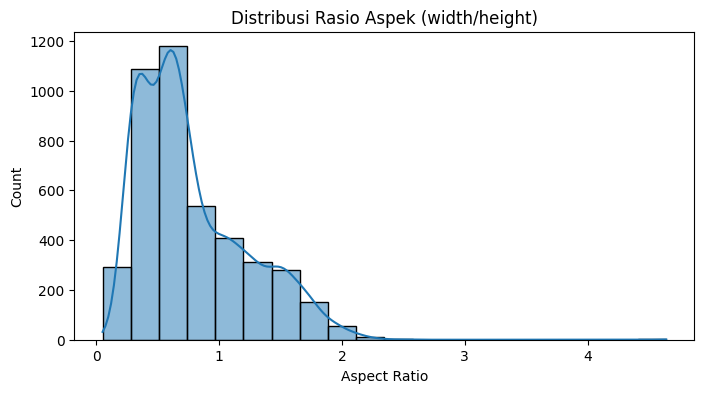

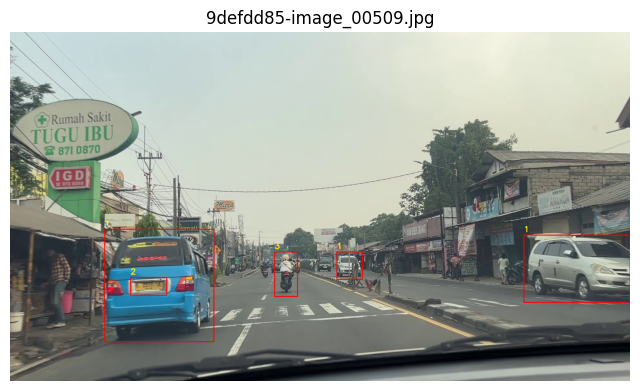

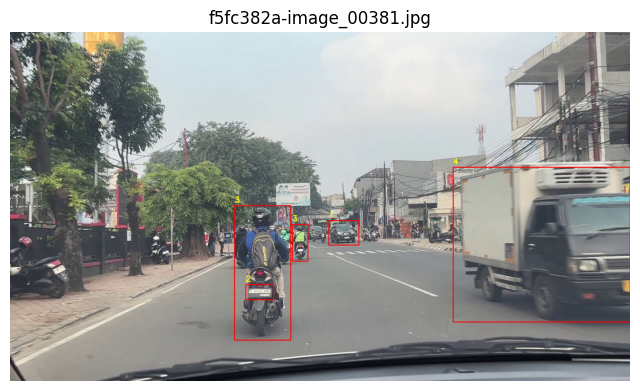

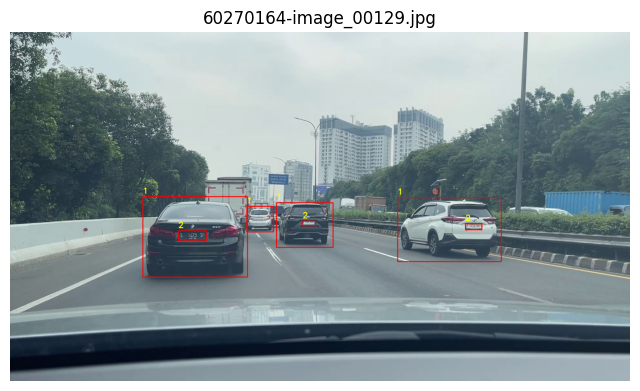

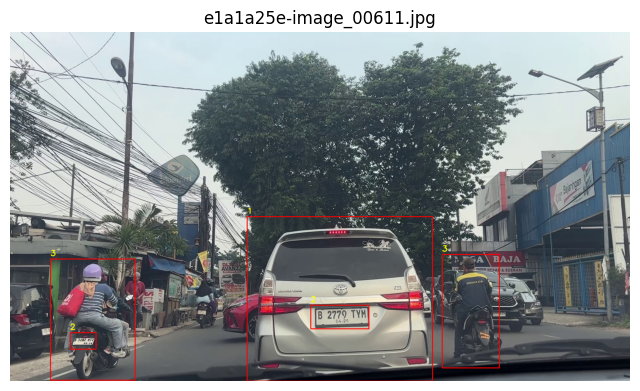

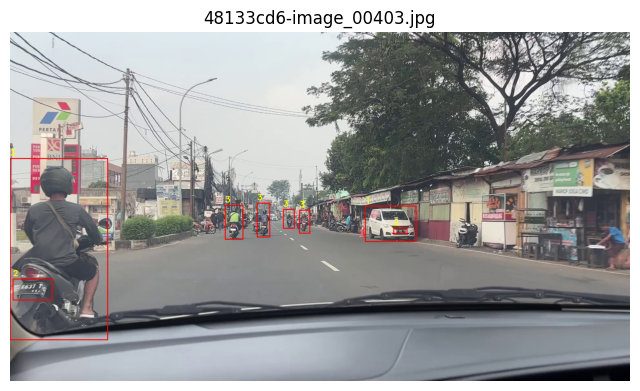

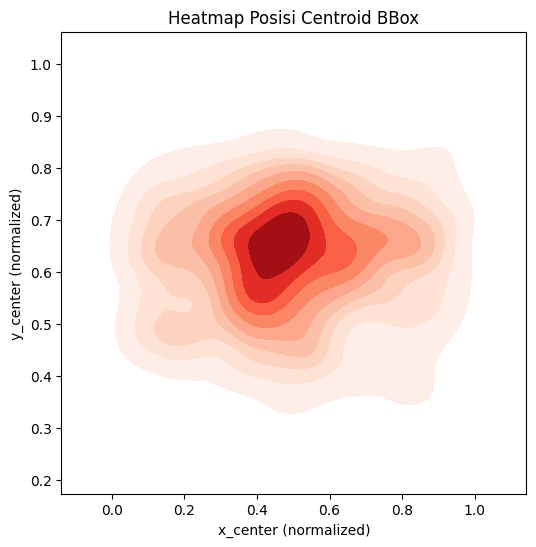

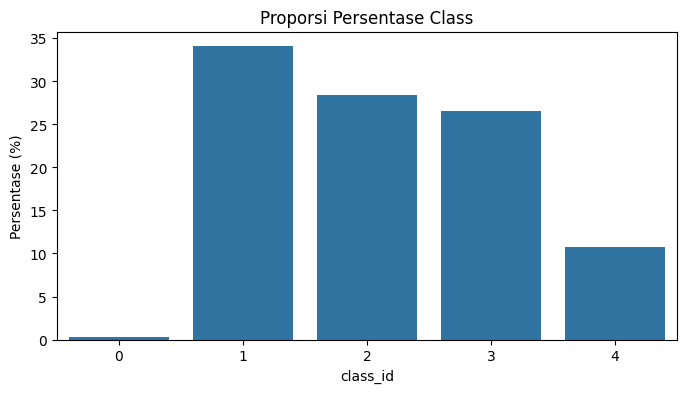

In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

records = []

image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]
for image_file in image_files:
    image_path = os.path.join(images_dir, image_file)
    label_file = image_file.replace('.jpg', '.txt')
    label_path = os.path.join(labels_dir, label_file)

    if not os.path.exists(label_path):
        continue

    image = plt.imread(image_path)
    h, w = image.shape[:2]

    with open(label_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            class_id = int(parts[0])
            x_center = float(parts[1])
            y_center = float(parts[2])
            width = float(parts[3])
            height = float(parts[4])

            records.append({
                'image': image_file,
                'class_id': class_id,
                'x_center': x_center,
                'y_center': y_center,
                'width': width,
                'height': height,
                'area': width * height,
                'aspect_ratio': width / height if height != 0 else 0
            })

df = pd.DataFrame(records)

# 1️⃣ Distribusi jumlah objek per class
plt.figure(figsize=(8,4))
sns.countplot(x='class_id', data=df)
plt.title('Distribusi Jumlah Objek per Class')
plt.show()

# 2️⃣ Distribusi jumlah objek per gambar
obj_per_image = df.groupby('image').size()
plt.figure(figsize=(8,4))
sns.histplot(obj_per_image, bins=20, kde=False)
plt.title('Distribusi Jumlah Objek per Gambar')
plt.xlabel('Jumlah Objek')
plt.ylabel('Jumlah Gambar')
plt.show()

# 3️⃣ Distribusi ukuran bbox (area)
plt.figure(figsize=(8,4))
sns.histplot(df['area'], bins=20, kde=True)
plt.title('Distribusi Ukuran Bounding Box (area)')
plt.xlabel('Area (normalized)')
plt.show()

# 4️⃣ Distribusi rasio aspek bbox
plt.figure(figsize=(8,4))
sns.histplot(df['aspect_ratio'], bins=20, kde=True)
plt.title('Distribusi Rasio Aspek (width/height)')
plt.xlabel('Aspect Ratio')
plt.show()

# 5️⃣ Visualisasi 5 gambar random + bbox
import cv2
sample_images = df['image'].unique()
sample_images = np.random.choice(sample_images, size=min(5, len(sample_images)), replace=False)

for image_file in sample_images:
    image_path = os.path.join(images_dir, image_file)
    label_path = os.path.join(labels_dir, image_file.replace('.jpg', '.txt'))

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape

    boxes = df[df['image']==image_file]
    for _, row in boxes.iterrows():
        xmin = int((row['x_center'] - row['width']/2) * w)
        ymin = int((row['y_center'] - row['height']/2) * h)
        xmax = int((row['x_center'] + row['width']/2) * w)
        ymax = int((row['y_center'] + row['height']/2) * h)
        class_id = row['class_id']

        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255,0,0), 2)
        cv2.putText(image, str(class_id), (xmin, ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,0), 2)

    plt.figure(figsize=(8,8))
    plt.imshow(image)
    plt.title(image_file)
    plt.axis('off')
    plt.show()

# 6️⃣ Heatmap sebaran posisi centroid bbox
plt.figure(figsize=(6,6))
sns.kdeplot(x=df['x_center'], y=df['y_center'], fill=True, cmap='Reds')
plt.title('Heatmap Posisi Centroid BBox')
plt.xlabel('x_center (normalized)')
plt.ylabel('y_center (normalized)')
plt.show()

# 7️⃣ Proporsi persentase class
class_counts = df['class_id'].value_counts(normalize=True) * 100
plt.figure(figsize=(8,4))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Proporsi Persentase Class')
plt.ylabel('Persentase (%)')
plt.show()


In [9]:
from ultralytics import YOLO

# Load model YOLOv8 pretrained (misal YOLOv8n = nano, bisa diganti v8s/v8m/v8l)
model = YOLO('yolov8n.pt')

# Train
model.train(
    data='Dataset/data.yaml',
    epochs=50, 
    batch=16,
    imgsz=640, 
    device='0', 
    patience=5          
)

Creating new Ultralytics Settings v0.0.6 file  
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\faish\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 11.3MB/s]


Ultralytics 8.3.165  Python-3.9.23 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=Dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=5, perspective=0.0, plots=True, pose=12.0, pre

100%|██████████| 755k/755k [00:00<00:00, 7.92MB/s]

Overriding model.yaml nc=80 with nc=5

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

 22        [15, 18, 21]  1    752287  ultralytics.nn.modules.head.Detect           [5, [64, 128, 256]]           
Model summary: 129 layers, 3,011,823 parameters, 3,011,807 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 11.1MB/s]


AMP: checks passed 
train: Fast image access  (ping: 0.10.0 ms, read: 564.1295.8 MB/s, size: 1002.1 KB)


train: Scanning C:\Vike Data\4. Study\Hacktiv8\Final Project\Dataset\train\labels... 758 images, 1 backgrounds, 0 corrupt: 100%|██████████| 758/758 [00:00<00:00, 1490.86it/s]


train: New cache created: C:\Vike Data\4. Study\Hacktiv8\Final Project\Dataset\train\labels.cache
val: Fast image access  (ping: 0.70.1 ms, read: 18.45.1 MB/s, size: 483.2 KB)


val: Scanning C:\Vike Data\4. Study\Hacktiv8\Final Project\Dataset\val\labels... 162 images, 0 backgrounds, 0 corrupt: 100%|██████████| 162/162 [00:01<00:00, 117.21it/s]

val: New cache created: C:\Vike Data\4. Study\Hacktiv8\Final Project\Dataset\val\labels.cache


Plotting labels to runs\detect\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.06G      1.361      2.391      1.141         53        640: 100%|██████████| 48/48 [00:12<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.80it/s]


                   all        162        923       0.99      0.158      0.373      0.255

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.08G      1.271      1.384      1.094         36        640: 100%|██████████| 48/48 [00:09<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.70it/s]

                   all        162        923      0.648      0.399      0.561      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50       2.1G      1.242      1.209      1.091         64        640: 100%|██████████| 48/48 [00:09<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.51it/s]

                   all        162        923      0.631      0.577      0.655      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.12G      1.199      1.118      1.067         61        640: 100%|██████████| 48/48 [00:08<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.87it/s]

                   all        162        923      0.839      0.557      0.636      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.13G      1.161      1.054      1.059         40        640: 100%|██████████| 48/48 [00:08<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.74it/s]

                   all        162        923      0.764      0.577      0.678      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.15G      1.139     0.9741       1.05         60        640: 100%|██████████| 48/48 [00:08<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.73it/s]

                   all        162        923      0.795      0.696      0.764      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.17G      1.112      0.939      1.038         48        640: 100%|██████████| 48/48 [00:08<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.88it/s]

                   all        162        923      0.827      0.761      0.813      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.18G      1.101      0.931      1.033         68        640: 100%|██████████| 48/48 [00:08<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.72it/s]

                   all        162        923      0.726      0.664      0.722      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50       2.2G      1.088     0.8897      1.023         90        640: 100%|██████████| 48/48 [00:08<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.80it/s]

                   all        162        923      0.912      0.701      0.813      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.22G      1.068     0.8339      1.015         70        640: 100%|██████████| 48/48 [00:08<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.68it/s]

                   all        162        923      0.746      0.811      0.814       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.23G      1.058     0.8228      1.011         62        640: 100%|██████████| 48/48 [00:08<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.70it/s]

                   all        162        923      0.773      0.773      0.837      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.25G      1.034     0.7948      1.006         58        640: 100%|██████████| 48/48 [00:08<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.00it/s]

                   all        162        923      0.852      0.798      0.836      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.27G      1.045     0.7815      1.005         91        640: 100%|██████████| 48/48 [00:08<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.95it/s]

                   all        162        923      0.898      0.775       0.86      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.29G      1.016     0.7558     0.9966         49        640: 100%|██████████| 48/48 [00:08<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.02it/s]

                   all        162        923       0.86      0.768      0.863      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50       2.3G       1.01     0.7337     0.9909         68        640: 100%|██████████| 48/48 [00:08<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.66it/s]

                   all        162        923      0.867      0.784      0.859      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.32G      1.013     0.7336     0.9988         43        640: 100%|██████████| 48/48 [00:08<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.82it/s]

                   all        162        923      0.824      0.787      0.865      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.34G       0.99     0.7131     0.9873         52        640: 100%|██████████| 48/48 [00:08<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.63it/s]

                   all        162        923      0.853      0.833       0.87      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.35G      1.007     0.7099     0.9909         62        640: 100%|██████████| 48/48 [00:08<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.78it/s]

                   all        162        923      0.808       0.78      0.839      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.37G     0.9916     0.6973     0.9806         53        640: 100%|██████████| 48/48 [00:09<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.29it/s]

                   all        162        923      0.879      0.798      0.875      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.39G          1     0.6922     0.9905         59        640: 100%|██████████| 48/48 [00:09<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.45it/s]

                   all        162        923      0.801      0.803      0.879      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50       2.4G     0.9756     0.6821     0.9748         82        640: 100%|██████████| 48/48 [00:08<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.04it/s]

                   all        162        923      0.849      0.864       0.89      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.42G     0.9706     0.6734      0.979         88        640: 100%|██████████| 48/48 [00:08<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.85it/s]

                   all        162        923      0.824      0.831      0.871      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.44G      0.959     0.6554      0.974         56        640: 100%|██████████| 48/48 [00:08<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.70it/s]

                   all        162        923      0.879      0.775      0.865      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.46G      0.958     0.6455     0.9679         77        640: 100%|██████████| 48/48 [00:08<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.93it/s]

                   all        162        923      0.846      0.786      0.872      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.47G     0.9411     0.6368     0.9627         72        640: 100%|██████████| 48/48 [00:10<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.25it/s]

                   all        162        923      0.872       0.81      0.873      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.49G     0.9376     0.6317     0.9663         43        640: 100%|██████████| 48/48 [00:09<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.35it/s]

                   all        162        923      0.833       0.82      0.871      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.51G     0.9354     0.6221     0.9697         84        640: 100%|██████████| 48/48 [00:09<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.82it/s]

                   all        162        923      0.874      0.805      0.887      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.52G     0.9204       0.61      0.962         46        640: 100%|██████████| 48/48 [00:09<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.98it/s]

                   all        162        923      0.882      0.795      0.887       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.54G      0.922     0.6034     0.9624         60        640: 100%|██████████| 48/48 [00:10<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.66it/s]

                   all        162        923      0.891      0.848      0.896      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.56G     0.9211     0.6044     0.9622         70        640: 100%|██████████| 48/48 [00:09<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.52it/s]

                   all        162        923      0.892      0.852      0.919       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.58G     0.9055     0.5931     0.9548         56        640: 100%|██████████| 48/48 [00:09<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.72it/s]

                   all        162        923      0.864      0.858      0.909      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.59G     0.9114       0.58     0.9529         80        640: 100%|██████████| 48/48 [00:08<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.95it/s]

                   all        162        923      0.841      0.863        0.9      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.61G     0.8939     0.5716      0.951         62        640: 100%|██████████| 48/48 [00:08<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.82it/s]

                   all        162        923      0.869      0.816      0.891      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.63G     0.8893     0.5744     0.9482         43        640: 100%|██████████| 48/48 [00:08<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.76it/s]

                   all        162        923      0.887      0.857      0.909      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.64G     0.8859     0.5684     0.9519         86        640: 100%|██████████| 48/48 [00:09<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.53it/s]

                   all        162        923      0.875      0.823      0.887       0.64
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 30, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



35 epochs completed in 0.106 hours.
Optimizer stripped from runs\detect\train\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train\weights\best.pt, 6.2MB

Validating runs\detect\train\weights\best.pt...
Ultralytics 8.3.165  Python-3.9.23 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


                   all        162        923      0.892      0.852      0.919       0.66
                   Bus          4          6          1      0.824      0.922      0.639
                   Car        142        351      0.907      0.918      0.961      0.764
          LicensePlate        137        246      0.858      0.764      0.869      0.511
            Motorcycle         88        200      0.803      0.895      0.903      0.595
                 Truck         63        120       0.89      0.858      0.941      0.792
Speed: 0.2ms preprocess, 1.8ms inference, 0.0ms loss, 6.1ms postprocess per image
Results saved to runs\detect\train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000259909789D0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
    


0: 384x640 2 Cars, 2 LicensePlates, 1 Truck, 21.8ms
Speed: 5.1ms preprocess, 21.8ms inference, 3.9ms postprocess per image at shape (1, 3, 384, 640)


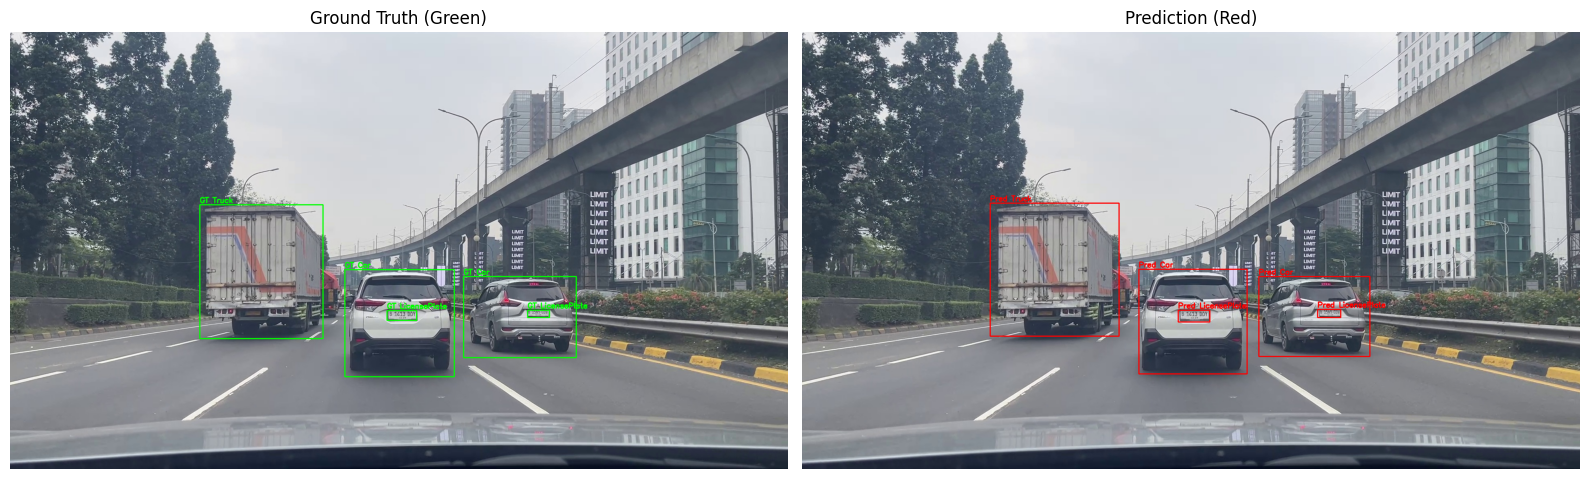


0: 384x640 3 Cars, 2 LicensePlates, 2 Motorcycles, 16.5ms
Speed: 3.8ms preprocess, 16.5ms inference, 5.1ms postprocess per image at shape (1, 3, 384, 640)


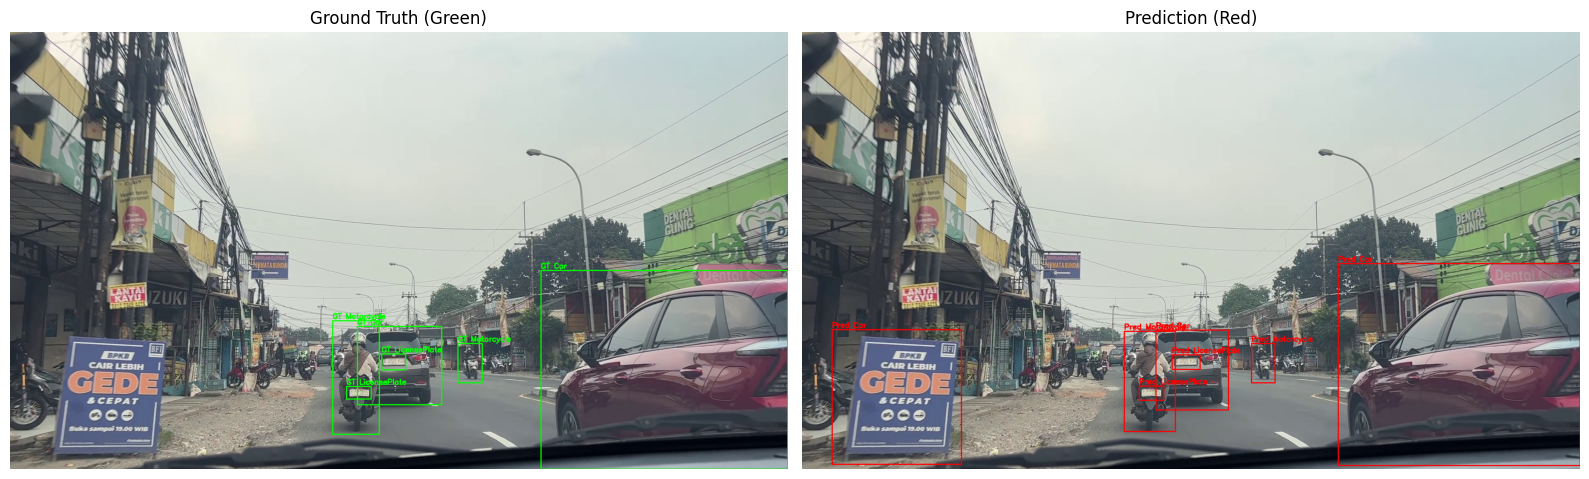


0: 384x640 4 Cars, 1 LicensePlate, 1 Truck, 18.9ms
Speed: 3.0ms preprocess, 18.9ms inference, 4.2ms postprocess per image at shape (1, 3, 384, 640)


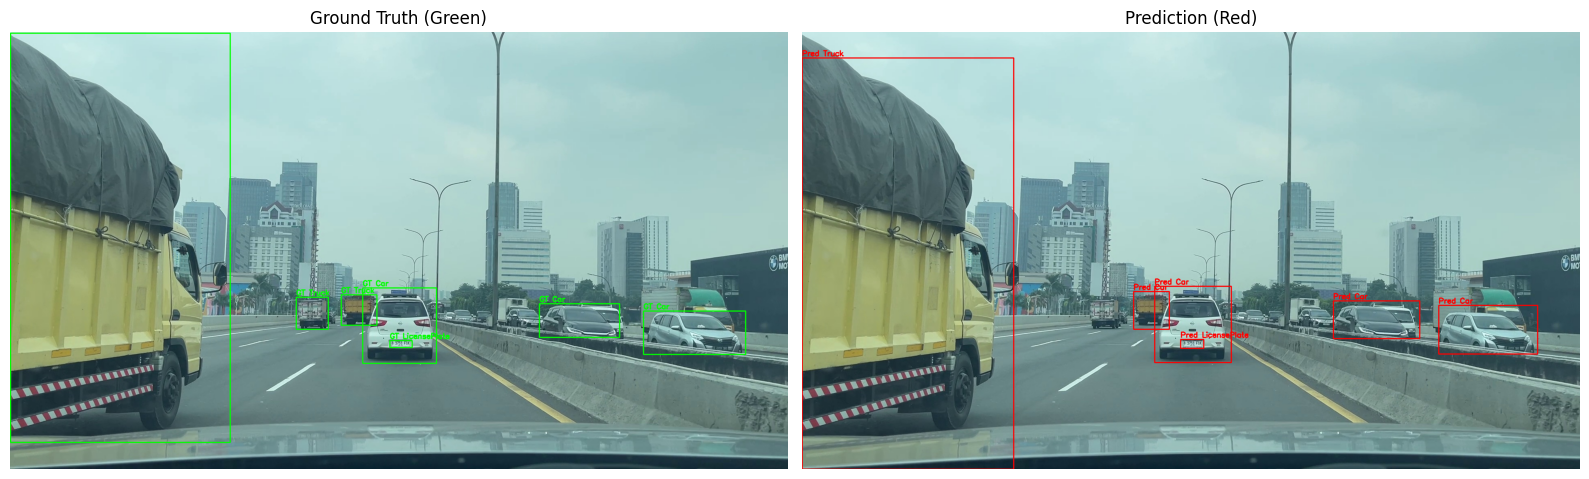


0: 384x640 1 Car, 2 LicensePlates, 2 Motorcycles, 15.6ms
Speed: 2.7ms preprocess, 15.6ms inference, 5.5ms postprocess per image at shape (1, 3, 384, 640)


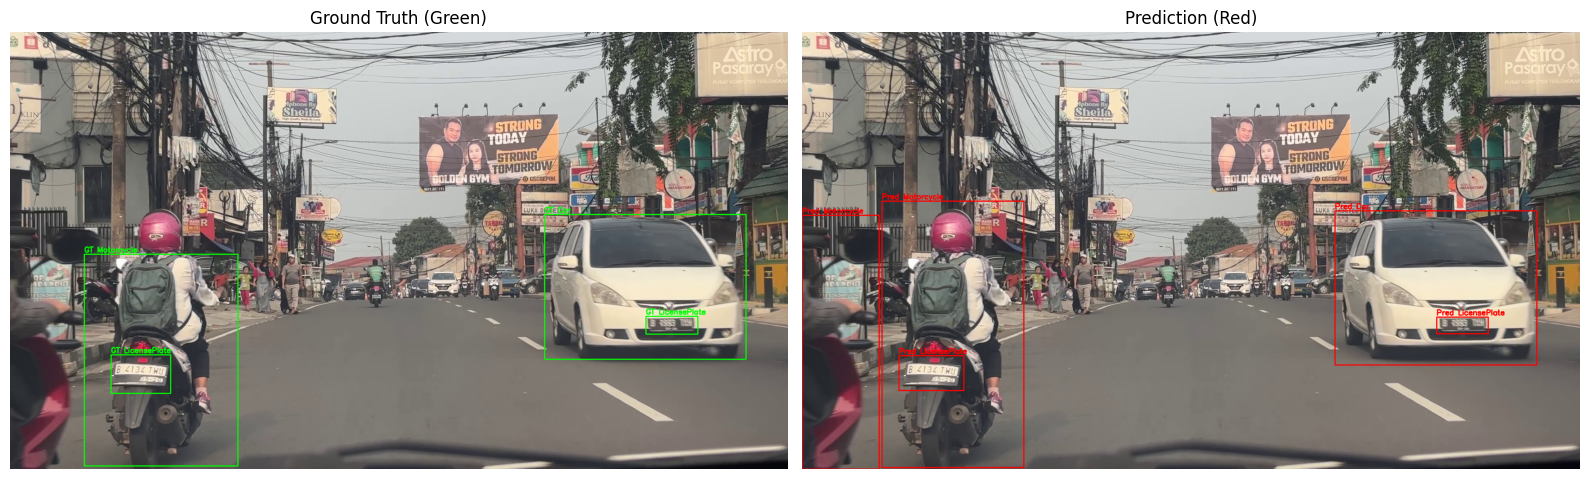


0: 384x640 1 Bus, 4 Cars, 3 LicensePlates, 5 Motorcycles, 1 Truck, 17.7ms
Speed: 4.9ms preprocess, 17.7ms inference, 4.8ms postprocess per image at shape (1, 3, 384, 640)


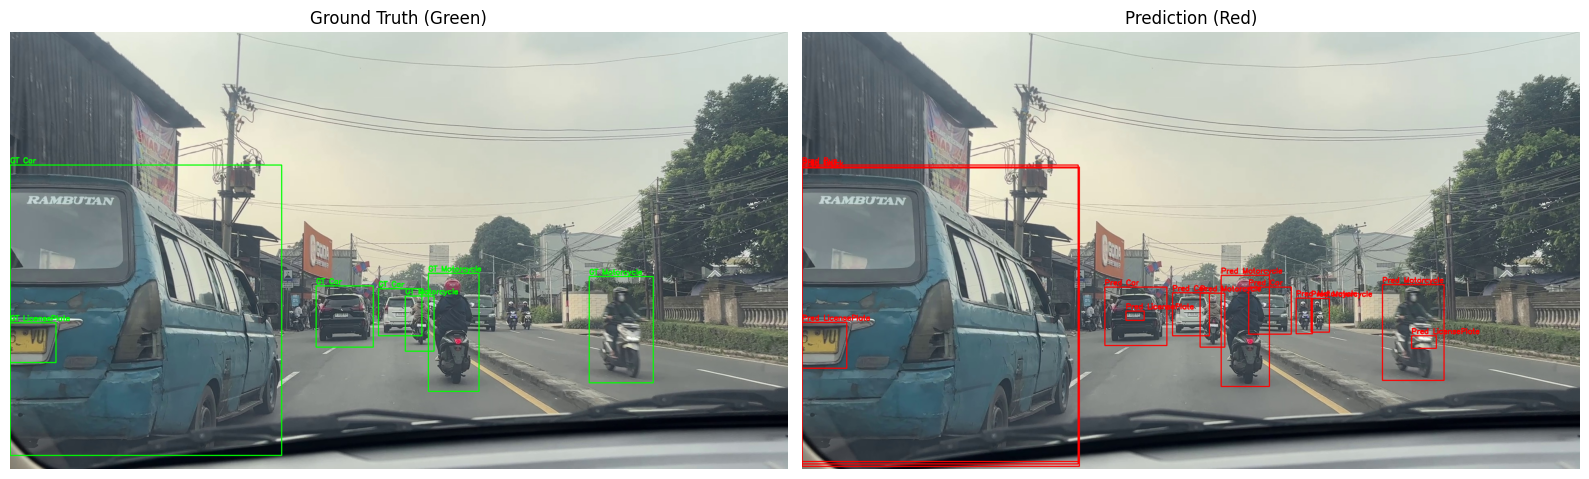

In [13]:
import os
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# === Paths ===
images_dir = 'Dataset/test/images'
labels_dir = 'Dataset/test/labels'
model_path = 'runs/detect/train/weights/best.pt'

# === Load model ===
model = YOLO(model_path)

# === Helper: load actual labels ===
def load_actual_boxes(label_path, img_width, img_height):
    boxes = []
    with open(label_path, 'r') as file:
        for line in file:
            cls, x_center, y_center, w, h = map(float, line.strip().split())
            # Convert from YOLO format to box coordinates
            x1 = int((x_center - w/2) * img_width)
            y1 = int((y_center - h/2) * img_height)
            x2 = int((x_center + w/2) * img_width)
            y2 = int((y_center + h/2) * img_height)
            boxes.append((int(cls), x1, y1, x2, y2))
    return boxes

# === Visualize a few predictions ===
image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')][:5]  # Limit to 5 for display

for image_file in image_files:
    img_path = os.path.join(images_dir, image_file)
    label_path = os.path.join(labels_dir, image_file.replace('.jpg', '.txt'))

    # Load image
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]

    # Get actual boxes
    actual_boxes = load_actual_boxes(label_path, w, h)

    # Get predictions
    results = model(img_rgb)[0]
    pred_boxes = []
    for box in results.boxes:
        cls = int(box.cls[0])
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        pred_boxes.append((cls, x1, y1, x2, y2))

    # Draw both images
    img_actual = img_rgb.copy()
    img_pred = img_rgb.copy()

    # Draw actual boxes in GREEN
    for cls, x1, y1, x2, y2 in actual_boxes:
        cv2.rectangle(img_actual, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img_actual, f"GT {classes[cls]}", (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)

    # Draw predicted boxes in RED
    for cls, x1, y1, x2, y2 in pred_boxes:
        cv2.rectangle(img_pred, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(img_pred, f"Pred {classes[cls]}", (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,0,0), 2)

    # Display side by side
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    axs[0].imshow(img_actual)
    axs[0].set_title("Ground Truth (Green)")
    axs[0].axis('off')

    axs[1].imshow(img_pred)
    axs[1].set_title("Prediction (Red)")
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# DOESNT WORK
# Load best trained model
model = YOLO('runs/detect/train/weights/best.pt')

metrics = model.val(split='test') 

# Optional: print key metrics
print("mAP50-95:", metrics.box.map) 
print("Precision:", metrics.box.precision)
print("Recall:", metrics.box.recall)

Ultralytics 8.3.165  Python-3.9.23 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.30.2 ms, read: 44.111.1 MB/s, size: 469.8 KB)


val: Scanning C:\Vike Data\4. Study\Hacktiv8\Final Project\Dataset\test\labels... 162 images, 0 backgrounds, 0 corrupt: 100%|██████████| 162/162 [00:00<00:00, 424.92it/s]


val: New cache created: C:\Vike Data\4. Study\Hacktiv8\Final Project\Dataset\test\labels.cache
